In [1]:
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras import backend as K
from imutils import paths
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import pickle
import cv2
import os

In [2]:
dataset_path = 'dataset_animals'
model_path = os.path.sep.join(['output', 'animal.model'])
le_path = os.path.sep.join(['output', 'le.pickle'])

In [3]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 32
IMAGE_DIMS =  (224, 224, 3)

In [4]:
data = []
labels = []

In [5]:
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(0)
random.shuffle(imagePaths)


In [6]:
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    assert os.path.isfile(imagePath)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-1]
    label = label.split('-')[0]
    labels.append(label)
    #print(label)

In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 75% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, random_state=0, stratify=labels)

data matrix: 2322.60MB


In [8]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [9]:
def lr_experiment():
    
    history = []
    
    for lr in [0.1, 0.01, 0.001,0.0001]:
        input_tensor = Input(shape=IMAGE_DIMS)
        base_model = MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_tensor=input_tensor,
                input_shape=IMAGE_DIMS,
                pooling='avg')
        
        head_model = base_model.output
        head_model = Flatten(name = 'flatten')(head_model)
        head_model = Dense(512, activation = 'relu')(head_model)
        head_model = Dropout(0.5)(head_model)
        
        output_tensor = Dense(10, activation='softmax')(head_model)
        model = Model(inputs=input_tensor, outputs=output_tensor)
        
        model.compile(SGD(lr=lr), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
        h = model.fit_generator(
                aug.flow(trainX, trainY, batch_size=BS),
                validation_data=(testX, testY),
                steps_per_epoch=len(trainX) // BS,
                epochs=EPOCHS, verbose=1)
        history.append(h)
    
    return history

history = lr_experiment()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
46/46 [==============================] - 127s 3s/step - loss: 1.4019 - accuracy: 0.5549 - top_k_categorical_accuracy: 0.9096 - val_loss: 6.6018 - val_accuracy: 0.0972 - val_top_k_categorical_accuracy: 0.5202
Epoch 2/50
46/46 [==============================] - 126s 3s/step - loss: 0.8383 - accuracy: 0.7267 - top_k_categorical_accuracy: 0.9772 - val_loss: 3.6504 - val_accuracy: 0.2976 - val_top_k_categorical_accuracy: 0.7227
Epoch 3/50
46/46 [==============================] - 654s 14s/step - loss: 0.7226 - accuracy: 0.7716 - top_k_categorical_accuracy: 0.9807 - val_loss: 3.6974 - val_accuracy: 0.3644 - val_top_k_categorical_accuracy: 0.7551
Epoch 4/50
46/46 [==============================] - 126s 3s/step - loss: 0.6378 - accuracy: 0.8116 - top_k_categorical_accuracy: 0.9862 - val_loss: 2.5134 - val_accuracy: 0.4575 - val_top_k_categorical_accuracy: 0.8077
Epoch 5/50
46/46 [=============================

46/46 [==============================] - 125s 3s/step - loss: 0.0729 - accuracy: 0.9772 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.3824 - val_accuracy: 0.5364 - val_top_k_categorical_accuracy: 0.8785
Epoch 38/50
46/46 [==============================] - 125s 3s/step - loss: 0.0650 - accuracy: 0.9807 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.7208 - val_accuracy: 0.6923 - val_top_k_categorical_accuracy: 0.9433
Epoch 39/50
46/46 [==============================] - 125s 3s/step - loss: 0.1613 - accuracy: 0.9565 - top_k_categorical_accuracy: 0.9979 - val_loss: 3.1693 - val_accuracy: 0.5263 - val_top_k_categorical_accuracy: 0.9413
Epoch 40/50
46/46 [==============================] - 125s 3s/step - loss: 0.0711 - accuracy: 0.9772 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6474 - val_accuracy: 0.6761 - val_top_k_categorical_accuracy: 0.9595
Epoch 41/50
46/46 [==============================] - 126s 3s/step - loss: 0.0579 - accuracy: 0.9855 - top_k_categorical_accuracy: 1.

46/46 [==============================] - 126s 3s/step - loss: 0.0423 - accuracy: 0.9862 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3709 - val_accuracy: 0.8968 - val_top_k_categorical_accuracy: 0.9980
Epoch 25/50
46/46 [==============================] - 126s 3s/step - loss: 0.0301 - accuracy: 0.9938 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.3371 - val_accuracy: 0.9028 - val_top_k_categorical_accuracy: 0.9980
Epoch 26/50
46/46 [==============================] - 126s 3s/step - loss: 0.0270 - accuracy: 0.9896 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3180 - val_accuracy: 0.9008 - val_top_k_categorical_accuracy: 1.0000
Epoch 27/50
46/46 [==============================] - 126s 3s/step - loss: 0.0440 - accuracy: 0.9827 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3247 - val_accuracy: 0.9130 - val_top_k_categorical_accuracy: 0.9980
Epoch 28/50
46/46 [==============================] - 128s 3s/step - loss: 0.0349 - accuracy: 0.9918 - top_k_categorical_accuracy: 1.

46/46 [==============================] - 126s 3s/step - loss: 0.6003 - accuracy: 0.8199 - top_k_categorical_accuracy: 0.9890 - val_loss: 0.6152 - val_accuracy: 0.7834 - val_top_k_categorical_accuracy: 0.9858
Epoch 12/50
46/46 [==============================] - 128s 3s/step - loss: 0.5705 - accuracy: 0.8254 - top_k_categorical_accuracy: 0.9862 - val_loss: 0.5842 - val_accuracy: 0.8077 - val_top_k_categorical_accuracy: 0.9858
Epoch 13/50
46/46 [==============================] - 126s 3s/step - loss: 0.5175 - accuracy: 0.8392 - top_k_categorical_accuracy: 0.9938 - val_loss: 0.5593 - val_accuracy: 0.8178 - val_top_k_categorical_accuracy: 0.9858
Epoch 14/50
46/46 [==============================] - 126s 3s/step - loss: 0.5092 - accuracy: 0.8357 - top_k_categorical_accuracy: 0.9890 - val_loss: 0.5163 - val_accuracy: 0.8360 - val_top_k_categorical_accuracy: 0.9858
Epoch 15/50
46/46 [==============================] - 127s 3s/step - loss: 0.4724 - accuracy: 0.8468 - top_k_categorical_accuracy: 0.

46/46 [==============================] - 131s 3s/step - loss: 0.1527 - accuracy: 0.9572 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.2545 - val_accuracy: 0.9190 - val_top_k_categorical_accuracy: 1.0000
Epoch 49/50
46/46 [==============================] - 131s 3s/step - loss: 0.1599 - accuracy: 0.9517 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9231 - val_top_k_categorical_accuracy: 1.0000
Epoch 50/50
46/46 [==============================] - 130s 3s/step - loss: 0.1353 - accuracy: 0.9614 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2429 - val_accuracy: 0.9211 - val_top_k_categorical_accuracy: 1.0000
Epoch 1/50
46/46 [==============================] - 134s 3s/step - loss: 2.6660 - accuracy: 0.1222 - top_k_categorical_accuracy: 0.5355 - val_loss: 2.5047 - val_accuracy: 0.1113 - val_top_k_categorical_accuracy: 0.5223
Epoch 2/50
46/46 [==============================] - 130s 3s/step - loss: 2.5683 - accuracy: 0.1546 - top_k_categorical_accuracy: 0.56

46/46 [==============================] - 128s 3s/step - loss: 1.4300 - accuracy: 0.5355 - top_k_categorical_accuracy: 0.9096 - val_loss: 1.2530 - val_accuracy: 0.6478 - val_top_k_categorical_accuracy: 0.9555
Epoch 36/50
46/46 [==============================] - 129s 3s/step - loss: 1.4012 - accuracy: 0.5452 - top_k_categorical_accuracy: 0.9055 - val_loss: 1.2322 - val_accuracy: 0.6518 - val_top_k_categorical_accuracy: 0.9595
Epoch 37/50
46/46 [==============================] - 128s 3s/step - loss: 1.3604 - accuracy: 0.5749 - top_k_categorical_accuracy: 0.9206 - val_loss: 1.2103 - val_accuracy: 0.6599 - val_top_k_categorical_accuracy: 0.9615
Epoch 38/50
46/46 [==============================] - 128s 3s/step - loss: 1.3862 - accuracy: 0.5638 - top_k_categorical_accuracy: 0.9117 - val_loss: 1.1911 - val_accuracy: 0.6721 - val_top_k_categorical_accuracy: 0.9636
Epoch 39/50
46/46 [==============================] - 129s 3s/step - loss: 1.3312 - accuracy: 0.5804 - top_k_categorical_accuracy: 0.

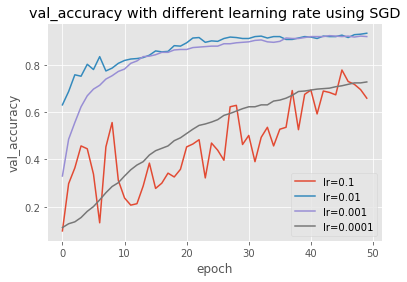

In [15]:
plt.style.use("ggplot")
plt.plot(history[0].history['val_accuracy'])
plt.plot(history[1].history['val_accuracy'])
plt.plot(history[2].history['val_accuracy'])
plt.plot(history[3].history['val_accuracy'])
plt.title('val_accuracy with different learning rate using SGD')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()

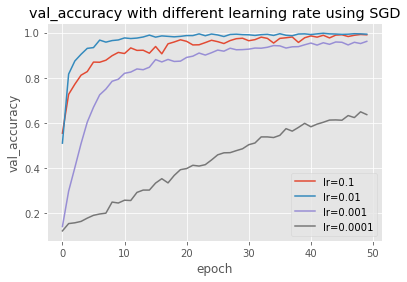

In [16]:
plt.style.use("ggplot")
plt.plot(history[0].history['accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[3].history['accuracy'])
plt.title('val_accuracy with different learning rate using SGD')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()

In [11]:
def lr_experiment_with_Adam():
    
    history = []
    
    for lr in [0.1, 0.01, 0.001,0.0001]:
        input_tensor = Input(shape=IMAGE_DIMS)
        base_model = MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_tensor=input_tensor,
                input_shape=IMAGE_DIMS,
                pooling='avg')
        
        head_model = base_model.output
        head_model = Flatten(name = 'flatten')(head_model)
        head_model = Dense(512, activation = 'relu')(head_model)
        head_model = Dropout(0.5)(head_model)
        
        output_tensor = Dense(10, activation='softmax')(head_model)
        model = Model(inputs=input_tensor, outputs=output_tensor)
        
        model.compile(Adam(lr=lr), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
        h = model.fit_generator(
                aug.flow(trainX, trainY, batch_size=BS),
                validation_data=(testX, testY),
                steps_per_epoch=len(trainX) // BS,
                epochs=EPOCHS, verbose=1)
        history.append(h)
    
    return history

history_Adam = lr_experiment_with_Adam()

Epoch 1/50
46/46 [==============================] - 130s 3s/step - loss: 13.9075 - accuracy: 0.1173 - top_k_categorical_accuracy: 0.5335 - val_loss: 31.7923 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.5526
Epoch 2/50
46/46 [==============================] - 127s 3s/step - loss: 2.2995 - accuracy: 0.1166 - top_k_categorical_accuracy: 0.5390 - val_loss: 2.5682 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.5324
Epoch 3/50
46/46 [==============================] - 127s 3s/step - loss: 2.2999 - accuracy: 0.1173 - top_k_categorical_accuracy: 0.5397 - val_loss: 13.8125 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.5162
Epoch 4/50
46/46 [==============================] - 127s 3s/step - loss: 2.3082 - accuracy: 0.1194 - top_k_categorical_accuracy: 0.5556 - val_loss: 26.2177 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.4879
Epoch 5/50
46/46 [==============================] - 130s 3s/step - loss: 2.3086 - accuracy: 0.1153 - top_k_categorical_a

46/46 [==============================] - 125s 3s/step - loss: 2.3044 - accuracy: 0.1028 - top_k_categorical_accuracy: 0.5266 - val_loss: 2.2981 - val_accuracy: 0.1316 - val_top_k_categorical_accuracy: 0.5547
Epoch 39/50
46/46 [==============================] - 125s 3s/step - loss: 2.3005 - accuracy: 0.1159 - top_k_categorical_accuracy: 0.5556 - val_loss: 2.3029 - val_accuracy: 0.1316 - val_top_k_categorical_accuracy: 0.5283
Epoch 40/50
46/46 [==============================] - 125s 3s/step - loss: 2.3006 - accuracy: 0.1166 - top_k_categorical_accuracy: 0.5645 - val_loss: 2.2981 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.5506
Epoch 41/50
46/46 [==============================] - 125s 3s/step - loss: 2.3046 - accuracy: 0.1090 - top_k_categorical_accuracy: 0.5390 - val_loss: 2.3000 - val_accuracy: 0.1316 - val_top_k_categorical_accuracy: 0.5506
Epoch 42/50
46/46 [==============================] - 125s 3s/step - loss: 2.2997 - accuracy: 0.1270 - top_k_categorical_accuracy: 0.

46/46 [==============================] - 128s 3s/step - loss: 1.4856 - accuracy: 0.4658 - top_k_categorical_accuracy: 0.9055 - val_loss: 3.6301 - val_accuracy: 0.1781 - val_top_k_categorical_accuracy: 0.5000
Epoch 26/50
46/46 [==============================] - 127s 3s/step - loss: 1.5055 - accuracy: 0.4500 - top_k_categorical_accuracy: 0.9068 - val_loss: 3.4606 - val_accuracy: 0.1255 - val_top_k_categorical_accuracy: 0.5891
Epoch 27/50
46/46 [==============================] - 128s 3s/step - loss: 1.4950 - accuracy: 0.4672 - top_k_categorical_accuracy: 0.9110 - val_loss: 8.9581 - val_accuracy: 0.1215 - val_top_k_categorical_accuracy: 0.5506
Epoch 28/50
46/46 [==============================] - 127s 3s/step - loss: 1.4329 - accuracy: 0.4748 - top_k_categorical_accuracy: 0.9248 - val_loss: 27.0949 - val_accuracy: 0.1012 - val_top_k_categorical_accuracy: 0.4453
Epoch 29/50
46/46 [==============================] - 127s 3s/step - loss: 1.4591 - accuracy: 0.4748 - top_k_categorical_accuracy: 0

46/46 [==============================] - 132s 3s/step - loss: 0.3068 - accuracy: 0.9096 - top_k_categorical_accuracy: 0.9952 - val_loss: 8.7074 - val_accuracy: 0.3036 - val_top_k_categorical_accuracy: 0.8360
Epoch 13/50
46/46 [==============================] - 132s 3s/step - loss: 0.2711 - accuracy: 0.9199 - top_k_categorical_accuracy: 0.9993 - val_loss: 5.2132 - val_accuracy: 0.3704 - val_top_k_categorical_accuracy: 0.8563
Epoch 14/50
46/46 [==============================] - 131s 3s/step - loss: 0.2037 - accuracy: 0.9372 - top_k_categorical_accuracy: 0.9979 - val_loss: 4.8635 - val_accuracy: 0.4332 - val_top_k_categorical_accuracy: 0.8482
Epoch 15/50
46/46 [==============================] - 129s 3s/step - loss: 0.1949 - accuracy: 0.9344 - top_k_categorical_accuracy: 0.9993 - val_loss: 5.7346 - val_accuracy: 0.4231 - val_top_k_categorical_accuracy: 0.7024
Epoch 16/50
46/46 [==============================] - 131s 3s/step - loss: 0.3187 - accuracy: 0.9103 - top_k_categorical_accuracy: 0.

46/46 [==============================] - 127s 3s/step - loss: 0.1366 - accuracy: 0.9634 - top_k_categorical_accuracy: 0.9979 - val_loss: 7.7201 - val_accuracy: 0.3543 - val_top_k_categorical_accuracy: 0.8158
Epoch 50/50
46/46 [==============================] - 132s 3s/step - loss: 0.0864 - accuracy: 0.9731 - top_k_categorical_accuracy: 0.9986 - val_loss: 7.9870 - val_accuracy: 0.3300 - val_top_k_categorical_accuracy: 0.8016
Epoch 1/50
46/46 [==============================] - 133s 3s/step - loss: 1.5090 - accuracy: 0.4983 - top_k_categorical_accuracy: 0.8558 - val_loss: 0.8647 - val_accuracy: 0.6923 - val_top_k_categorical_accuracy: 0.9899
Epoch 2/50
46/46 [==============================] - 129s 3s/step - loss: 0.5484 - accuracy: 0.8364 - top_k_categorical_accuracy: 0.9890 - val_loss: 0.5406 - val_accuracy: 0.8077 - val_top_k_categorical_accuracy: 0.9899
Epoch 3/50
46/46 [==============================] - 131s 3s/step - loss: 0.3498 - accuracy: 0.8854 - top_k_categorical_accuracy: 0.995

46/46 [==============================] - 131s 3s/step - loss: 0.0528 - accuracy: 0.9807 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5674 - val_accuracy: 0.8866 - val_top_k_categorical_accuracy: 0.9919
Epoch 37/50
46/46 [==============================] - 128s 3s/step - loss: 0.0299 - accuracy: 0.9910 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4996 - val_accuracy: 0.8947 - val_top_k_categorical_accuracy: 0.9980
Epoch 38/50
46/46 [==============================] - 130s 3s/step - loss: 0.0308 - accuracy: 0.9862 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3644 - val_accuracy: 0.9251 - val_top_k_categorical_accuracy: 0.9960
Epoch 39/50
46/46 [==============================] - 129s 3s/step - loss: 0.0377 - accuracy: 0.9862 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3832 - val_accuracy: 0.9251 - val_top_k_categorical_accuracy: 0.9960
Epoch 40/50
46/46 [==============================] - 129s 3s/step - loss: 0.0212 - accuracy: 0.9924 - top_k_categorical_accuracy: 1.

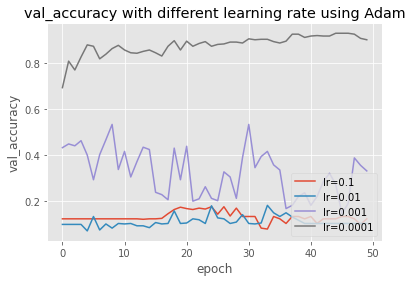

In [17]:
plt.style.use("ggplot")
plt.plot(history_Adam[0].history['val_accuracy'])
plt.plot(history_Adam[1].history['val_accuracy'])
plt.plot(history_Adam[2].history['val_accuracy'])
plt.plot(history_Adam[3].history['val_accuracy'])
plt.title('val_accuracy with different learning rate using Adam')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()

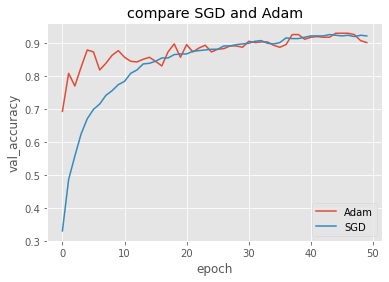

In [25]:
plt.style.use("ggplot")
plt.plot(history_Adam[3].history['val_accuracy'])
plt.plot(history[2].history['val_accuracy'])

plt.title('compare SGD and Adam')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD'], loc='lower right')
plt.show()

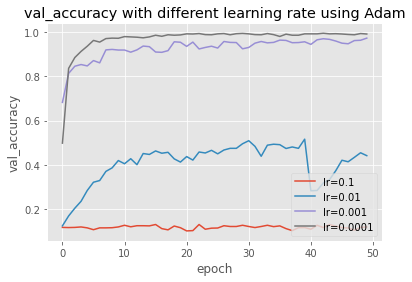

In [18]:
plt.style.use("ggplot")
plt.plot(history_Adam[0].history['accuracy'])
plt.plot(history_Adam[1].history['accuracy'])
plt.plot(history_Adam[2].history['accuracy'])
plt.plot(history_Adam[3].history['accuracy'])
plt.title('val_accuracy with different learning rate using Adam')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()

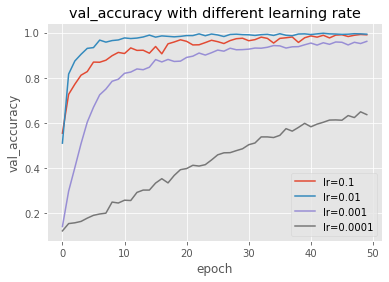

In [13]:
plt.style.use("ggplot")
plt.plot(history[0].history['accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[3].history['accuracy'])
plt.title('val_accuracy with different learning rate')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()

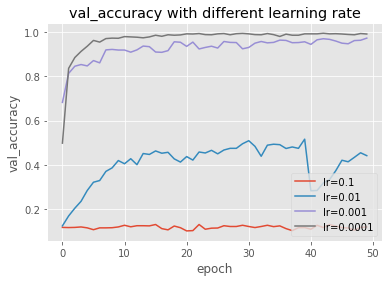

In [14]:
plt.style.use("ggplot")
plt.plot(history_Adam[0].history['accuracy'])
plt.plot(history_Adam[1].history['accuracy'])
plt.plot(history_Adam[2].history['accuracy'])
plt.plot(history_Adam[3].history['accuracy'])
plt.title('val_accuracy with different learning rate')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['lr=0.1', 'lr=0.01','lr=0.001','lr=0.0001'], loc='lower right')
plt.show()